- look into architechture modification and add numerical values as concatenation

https://sbert.net/docs/sentence_transformer/training_overview.html#dataset-format

In [1]:
%pip install accelerate

#%pip install accelerate==0.27.2
%pip install sentence-transformers
%pip install umap-learn
#%pip install cleodata --extra-index-url "https://aws:$(aws codeartifact get-authorization-token --domain meetcleo --domain-owner 878877078763 --query authorizationToken --output text)@meetcleo-878877078763.d.codeartifact.us-east-1.amazonaws.com/pypi/meetcleo-releases/simple/"

Note: you may need to restart the kernel to use updated packages.
  Using cached sentence_transformers-3.0.1-py3-none-any.whl.metadata (10 kB)
  Using cached transformers-4.41.2-py3-none-any.whl.metadata (43 kB)
  Using cached tokenizers-0.19.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
Using cached sentence_transformers-3.0.1-py3-none-any.whl (227 kB)
Using cached transformers-4.41.2-py3-none-any.whl (9.1 MB)
Using cached tokenizers-0.19.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.13.3
    Uninstalling tokenizers-0.13.3:
      Successfully uninstalled tokenizers-0.13.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.31.0
    Uninstalling transformers-4.31.0:
      Successfully uninstalled transformers-4.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are install

In [4]:
%pip install awswrangler
# %pip install --upgrade sentence_transformers

  Using cached awswrangler-3.8.0-py3-none-any.whl.metadata (17 kB)
Using cached awswrangler-3.8.0-py3-none-any.whl (380 kB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
from datetime import datetime
import awswrangler as wr
import boto3
from botocore.exceptions import ClientError
from io import StringIO
#from fastparquet import ParquetFile
#boto3.setup_default_session(profile_name='DataScientist-878877078763')
# from cleodata.utils.secrets import get_secret
#from cleodata.sources.sync.sync import SyncDataSource
#redshift_source = SyncDataSource("data_exploration", use_redshift=True, redshift_cluster="cleo-production-redshift", redshift_db="cleo")

In [6]:
import pandas as pd
import torch
from sklearn.metrics.pairwise import cosine_similarity
import umap
from sentence_transformers import SentenceTransformer, models
from sentence_transformers import SentenceTransformer, InputExample
from torch.utils.data import DataLoader
from sentence_transformers import losses
from sklearn.model_selection import train_test_split

2024-06-17 16:31:22.809543: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
import torch
print(torch.__version__)

2.0.0.post200


In [8]:
%pip install sentence_transformers==3.0.1

Note: you may need to restart the kernel to use updated packages.


In [9]:
import sentence_transformers

In [10]:
sentence_transformers.__version__

'3.0.1'

In [11]:
print(torch.__version__)

2.0.0.post200


In [12]:
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from sentence_transformers.training_args import BatchSamplers
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, SimilarityFunction
from sentence_transformers import SentenceTransformerTrainer

args = SentenceTransformerTrainingArguments(
    # Required parameter:
    output_dir="/home/sagemaker-user/models/model11",
    # Optional training parameters:
    num_train_epochs=3,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    warmup_ratio=0.1,
    fp16=True,  # Set to False if you get an error that your GPU can't run on FP16
    bf16=False,  # Set to True if you have a GPU that supports BF16
    batch_sampler=BatchSamplers.NO_DUPLICATES,  # losses that use "in-batch negatives" benefit from no duplicates
    # Optional tracking/debugging parameters:
    evaluation_strategy="steps", #eval_strategy
    eval_steps=200,
    save_strategy="steps",
    save_steps=200,
    save_total_limit=200,
    logging_steps=100,
    run_name="test1",  # Will be used in W&B if `wandb` is installed
    load_best_model_at_end= True,
    logging_dir="/home/sagemaker-user/logs",
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [13]:
s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/trans_2024-05-14_2024-05-14_top_2001.parquet"
s3_path = "https://cleo-data-science.s3.amazonaws.com/transaction_enrichment/experimental_data/caste/trx-merchant-pair/trans_2024-05-18_2024-05-18_top_1_39000.parquet/"
s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/cons_2024-05-15_2024-05-18_1.parquet/"
s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/data_tmp_trans_23_06_24_06_pairs/tmp_trans_23_06_24_06_pairs"

df_data_raw = wr.s3.read_parquet(path=s3_path)
df_data_raw.shape

: 

: 

In [12]:
print(torch.cuda.device_count())

1


In [13]:
df_data_raw.head()

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label,label
0,9814634960,Purchase 7-ELEVEN SOLON OHUS. Channel: in stor...,Purchase 7-ELEVEN SOLON OHUS. Type: merchant. ...,Purchase 7-ELEVEN SOLON OHUS,7 Eleven,0,7 Eleven,-2.2,7 Eleven,1,0.920786
1,9821859383,7-ELEVEN EAST NORTHPOR NY 05/16. Channel: in s...,7-ELEVEN EAST NORTHPOR NY 05/16. Type: merchan...,7-ELEVEN EAST NORTHPOR NY 05/16,7 Eleven,0,7 Eleven,-29.2,7 Eleven,1,0.824660
2,9819736435,AVIAGAMES INC CA 05/16. Channel: online. Amoun...,AVIAGAMES INC CA 05/16. Type: merchant. Channe...,AVIAGAMES INC CA 05/16,Avia Games,0,Avia Games,-8.0,7 Eleven,0,0.043178
3,9819730103,ACIMA DIGITAL LLC DDA POS PURCHASE CD . Channe...,ACIMA DIGITAL LLC DDA POS PURCHASE CD . Type: ...,ACIMA DIGITAL LLC DDA POS PURCHASE CD,Acima,0,Acima,-120.3,7 Eleven,0,0.236403
4,9832980897,POS Debit - Visa Check Card - FLEX FINANCE HTT...,POS Debit - Visa Check Card - FLEX FINANCE HTT...,POS Debit - Visa Check Card - FLEX FINANCE HTT...,Flex Finance,0,Flex Finance,-505.0,7 Eleven,0,0.047083


In [14]:
#%pip install s3fs --upgrade
#import s3fs

In [15]:
df_ , df_test, y_, y_test = train_test_split(df_data_raw, df_data_raw['true_label'], test_size = 0.05, random_state=1)
df_train, df_val, y_train, y_val = train_test_split(df_, df_['true_label'], test_size = 0.1, random_state=1)
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
print(df_train.shape[0], df_val.shape[0], df_test.shape[0])

KeyboardInterrupt: 

In [ ]:
text_col = "description_combined_processed"

In [ ]:
df_train['len_sentence'] = df_train[text_col].apply(lambda x: len(x.split(' ')))
print(df_train['len_sentence'].max())

57


In [ ]:
from sentence_transformers import SentenceTransformer, models
from sentence_transformers import SentenceTransformer, InputExample
from torch.utils.data import DataLoader

In [ ]:

word_embedding_model = models.Transformer("bert-base-uncased", max_seq_length=128)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
#pd.set_option('display.float_format', lambda x: '%.f' % x)
#estimate maximum tokenized length
df_train['len_sentence'].describe()

count    9.575469e+06
mean     8.222131e+00
std      3.895720e+00
min      1.000000e+00
25%      5.000000e+00
50%      8.000000e+00
75%      1.100000e+01
max      5.700000e+01
Name: len_sentence, dtype: float64

In [ ]:
print(model.max_seq_length)
model.max_seq_length = 128
print(model.max_seq_length)

128
128


In [ ]:
df_train.head()

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label,label,len_sentence
0,9812915596,DUKEENERGY DES:BILL PAY ID: INDN:JESUS RAMIREZ...,DUKEENERGY DES:BILL PAY ID: INDN:JESUS RAMIREZ...,DUKEENERGY DES:BILL PAY ID: INDN:JESUS RAMIREZ...,Duke Energy,0,Duke Energy,-65.4,eBay,0,0.204800,9
1,9810168106,PURCHASE DD DOORDASH WALGREENS 855-973- CA . C...,PURCHASE DD DOORDASH WALGREENS 855-973- CA . T...,PURCHASE DD DOORDASH WALGREENS 855-973- CA,Walgreens,0,Walgreens,-46.8,Walgreens,1,0.975303,7
2,9833815955,PUBLIX # PINSON AL. Channel: in store. Amount:...,PUBLIX # PINSON AL. Type: merchant. Channel: i...,PUBLIX # PINSON AL,Publix,0,Publix,-12.7,Publix,1,0.840036,4
3,9798100046,VONS . Channel: in store. Amount: -10.7,VONS . Type: merchant. Channel: in store. Amou...,VONS,Vons Store,0,Vons Store,-10.7,Vons Store,1,0.644013,2
4,9818467537,GRID*Payment s4b7psgpm3 getgrid.app CA. Channe...,GRID*Payment s4b7psgpm3 getgrid.app CA. Type: ...,GRID*Payment s4b7psgpm3 getgrid.app CA,Grid,0,Grid,-63.0,Subway,0,0.115184,4


In [ ]:
one_sent = df_train[text_col][0]
print(df_train[text_col][1])

PURCHASE DD DOORDASH WALGREENS 855-973- CA 


In [ ]:
df_train['label'] = df_train['label'].astype('float32')
df_train['true_label'] = df_train['true_label'].astype('float32')
#train_examples = [InputExample(texts = [df_train.loc[i,'sentence'], df_train.loc[i,'merchant_name_combined']], label=df_train.loc[i,'true_label']  ) for i in range(df_train.shape[0])]

In [ ]:
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

In [ ]:
from torch.utils.data import Dataset, DataLoader
from sentence_transformers.losses import CoSENTLoss


In [ ]:
from datasets import Dataset

ds_train = Dataset.from_pandas(df_train[['true_label',text_col,'merchant_name_combined']])
ds_val = Dataset.from_pandas(df_val[['true_label',text_col,'merchant_name_combined']])
ds_test = Dataset.from_pandas(df_test[['true_label',text_col,'merchant_name_combined']])

ds_train = ds_train.rename_columns({"true_label": "score",text_col:"sentence1", "merchant_name_combined":"sentence2"})
ds_val = ds_val.rename_columns({"true_label": "score",text_col:"sentence1", "merchant_name_combined":"sentence2"})
ds_test = ds_test.rename_columns({"true_label": "score",text_col:"sentence1", "merchant_name_combined":"sentence2"})



In [ ]:
ds_test

Dataset({
    features: ['score', 'sentence1', 'sentence2'],
    num_rows: 559969
})

In [ ]:
import os
directory = "/home/sagemaker-user/logs"

# Check if the directory already exists
if not os.path.exists(directory):
    # Create the directory
    os.makedirs(directory)
    print("Directory created successfully!")
else:
    print("Directory already exists!")

Directory already exists!


In [ ]:
ds_val[0]

{'score': 0,
 'sentence1': '# MICROSOFT*XBOX REDMOND WA Card 20 # ',
 'sentence2': 'Bank of America ATM'}

In [ ]:
dev_evaluator = EmbeddingSimilarityEvaluator(
    sentences1=df_val[text_col],
    sentences2=df_val["merchant_name_combined"],
    scores=df_val["true_label"],
    main_similarity=SimilarityFunction.COSINE,
    name="sts-dev",
)

In [ ]:
#dev_evaluator(model)


In [ ]:
train_loss = CoSENTLoss(model)

In [ ]:
# 7. Create a trainer & train
trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    loss=train_loss,
    #evaluator=dev_evaluator,
)
trainer.train(resume_from_checkpoint="/home/sagemaker-user/models/model9/checkpoint-5000")


Detected kernel version 4.14.344, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


TypeError: TrainerState.__init__() got an unexpected keyword argument 'stateful_callbacks'

In [ ]:
# # (Optional) Evaluate the trained model on the test set
# test_evaluator = TripletEvaluator(
#     anchors=df_test["sentence"],
#     positives=df_test["true_merchant_name_combined"],
#     negatives=test_dataset["true_label"],
#     name="pairs-test1",
# )
# test_evaluator(model)

# 8. Save the trained model
model.save_pretrained("/home/sagemaker-user/models/model9final")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [ ]:
#!ls ./models/model1/checkpoint-600

1_Pooling			   scheduler.pt
README.md			   sentence_bert_config.json
config.json			   special_tokens_map.json
config_sentence_transformers.json  tokenizer.json
model.safetensors		   tokenizer_config.json
modules.json			   trainer_state.json
optimizer.pt			   training_args.bin
rng_state.pth			   vocab.txt


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
#copy 
import os
import boto3
from botocore.exceptions import NoCredentialsError, PartialCredentialsError

def upload_directory_to_s3(local_directory, bucket_name, s3_directory):
    s3_client = boto3.client('s3')

    for root, dirs, files in os.walk(local_directory):
        for file in files:
            local_path = os.path.join(root, file)
            relative_path = os.path.relpath(local_path, local_directory)
            s3_path = os.path.join(s3_directory, relative_path)

            try:
                s3_client.upload_file(local_path, bucket_name, s3_path)
                print(f'Successfully uploaded {local_path} to s3://{bucket_name}/{s3_path}')
            except FileNotFoundError:
                print(f'The file {local_path} was not found')
            except NoCredentialsError:
                print('Credentials not available')
            except PartialCredentialsError:
                print('Incomplete credentials provided')

# Example usage
local_directory = "/home/sagemaker-user/models/model4""
bucket_name = 'cleo-data-science'
s3_directory = "transaction_enrichment/experimental_data/caste/pairs_model/model4"

upload_directory_to_s3(local_directory, bucket_name, s3_directory)


Successfully uploaded ./models/model1/checkpoint-600/config_sentence_transformers.json to s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairs_model/model1-checkpoint600/config_sentence_transformers.json
Successfully uploaded ./models/model1/checkpoint-600/config.json to s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairs_model/model1-checkpoint600/config.json
Successfully uploaded ./models/model1/checkpoint-600/model.safetensors to s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairs_model/model1-checkpoint600/model.safetensors
Successfully uploaded ./models/model1/checkpoint-600/tokenizer_config.json to s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairs_model/model1-checkpoint600/tokenizer_config.json
Successfully uploaded ./models/model1/checkpoint-600/special_tokens_map.json to s3://cleo-data-science/transaction_enrichment/experimental_data/caste/pairs_model/model1-checkpoint600/special_t

In [ ]:
## 
#model = SentenceTransformer("./models/model1/checkpoint-600")


In [ ]:
list_unique_merchants = df_train['merchant_name_combined'].tolist()
embeddings_merchants = model.encode(list_unique_merchants)
embeddings_merchants.shape

In [ ]:
df_test['pred_merchant'] = None
df_test['pred_prob'] = 0.0
batch_size = 1000

In [ ]:
df_test.shape

(5000, 10)

In [ ]:
for istart in np.arange(0, df_test.shape[0]+1, batch_size):
    iend = min(df_test.shape[0],istart + batch_size)
    if iend> istart:
        print(istart, iend)
        tx_embeddings = model.encode(df_test['sentence'][istart:iend].tolist())
        similarities = model.similarity(tx_embeddings, embeddings_merchants)
        print(similarities.shape)
        max_vals = torch.max(similarities, axis=1)
        max_probs = max_vals[0]
        ix_max_merchants = max_vals[1]
        predicted_merchant = [list_unique_merchants[i] for i in ix_max_merchants]
        df_test.loc[istart:iend-1,'pred_merchant'] =  predicted_merchant
        df_test.loc[istart:iend-1,'pred_prob'] =  np.array(max_probs)

0 1000
torch.Size([1000, 85500])
1000 2000
torch.Size([1000, 85500])
2000 3000
torch.Size([1000, 85500])
3000 4000
torch.Size([1000, 85500])
4000 5000
torch.Size([1000, 85500])


In [ ]:
ntrue = df_test[df_test['pred_merchant'] == df_test['true_merchant_name_combined']].shape[0]

precision = ntrue/df_test.shape[0]
print(precision)

0.9052


In [ ]:
ntrue = df_test[(df_test['pred_merchant'] == df_test['true_merchant_name_combined']) & (df_test['pred_prob']>0.8)].shape[0]

accuracy = ntrue/df_test.shape[0]
print(accuracy)

In [ ]:
#tp/tp + fp



In [ ]:
df_no_match = df_test[df_test['pred_merchant'] != df_test['true_merchant_name_combined']]
df_no_match.reset_index(drop=True, inplace=True)
df_no_match

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,merchant_name_combined,true_label,label,pred_merchant,pred_prob
0,9796686754,Wal-Mart Super WAL-SAMS SPRINGFIELD MO. Channe...,Wal-Mart Super WAL-SAMS SPRINGFIELD MO. Type: ...,Wal-Mart Super WAL-SAMS SPRINGFIELD MO,Walmart,Smith''s,0,0.310292,Wal Wal-martsuper,0.799137
1,9799290885,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,Walmart,Synchrony,0,0.232759,Wal Wal-martsuper,0.775473
2,9798904474,Walmart.com Bentonville AR XX SIG PURCH 05/13 ...,Walmart.com Bentonville AR XX SIG PURCH 05/13 ...,Walmart.com Bentonville AR XX SIG PURCH 05/13 ...,Walmart,QuikTrip,0,0.075148,Wal Wal-martsuper,0.751793
3,9801927063,PURCHASE AUTHORIZED ON 05/11 WALMART.COM 800-9...,PURCHASE AUTHORIZED ON 05/11 WALMART.COM 800-9...,PURCHASE AUTHORIZED ON 05/11 WALMART.COM 800-9...,Walmart,Cash App,0,0.078535,Wal Wal-martsuper,0.735269
4,9799263021,05/13 22:02 WAL-MART # JONESBORO AR CKCD DEBIT...,05/13 22:02 WAL-MART # JONESBORO AR CKCD DEBIT...,05/13 22:02 WAL-MART # JONESBORO AR CKCD DEBIT,Walmart,Marathon Petroleum,0,0.257865,Wal Wal-martsuper,0.751371
...,...,...,...,...,...,...,...,...,...,...
469,9807244423,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,Walmart,Spinstersis,0,0.051089,Wal Wal-martsuper,0.772779
470,9808452776,Walmart.com 05/14 #XXXXX REFUND Walmart.com Be...,Walmart.com 05/14 #XXXXX REFUND Walmart.com Be...,Walmart.com 05/14 #XXXXX REFUND Walmart.com Be...,Walmart,K Stop Convenience,0,0.018743,Wal Wal-martsuper,0.713919
471,9798778036,Point of Sale Debit L341 TIME 04:30 PM DATE 05...,Point of Sale Debit L341 TIME 04:30 PM DATE 05...,Point of Sale Debit L341 TIME 04:30 PM DATE 05...,Walmart,Ross Stores,0,0.114881,Wal Wal-martsuper,0.766499
472,9807593604,CHECKCARD WALMART STA ELENA LA LIBERTAD XXXXX ...,CHECKCARD WALMART STA ELENA LA LIBERTAD XXXXX ...,CHECKCARD WALMART STA ELENA LA LIBERTAD XXXXX ...,Walmart,Lyft,0,0.116438,Wal Wal-martsuper,0.751746


In [ ]:
df_no_match.drop_duplicates(subset = ['true_merchant_name_combined','pred_merchant'])

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,merchant_name_combined,true_label,label,pred_merchant,pred_prob
0,9796686754,Wal-Mart Super WAL-SAMS SPRINGFIELD MO. Channe...,Wal-Mart Super WAL-SAMS SPRINGFIELD MO. Type: ...,Wal-Mart Super WAL-SAMS SPRINGFIELD MO,Walmart,Smith''s,0,0.310292,Wal Wal-martsuper,0.799137
13,9799066977,ONLINE TRANSFER FROM MCDONALD J WELLS FARGO CL...,ONLINE TRANSFER FROM MCDONALD J WELLS FARGO CL...,ONLINE TRANSFER FROM MCDONALD J WELLS FARGO CL...,Wells Fargo,Empower,0,0.416453,McDonald''s,0.939226
18,9813217231,POS PURCHASE POS WM SUPERCENTER GREENVILLE PA....,POS PURCHASE POS WM SUPERCENTER GREENVILLE PA....,POS PURCHASE POS WM SUPERCENTER GREENVILLE PA,Walmart,RaceTrac,0,0.288263,McDonald''s,0.630497
36,9795670664,POS PURCH : WM SUPERCENTER # GA BAXLEY WM SUPE...,POS PURCH : WM SUPERCENTER # GA BAXLEY WM SUPE...,POS PURCH : WM SUPERCENTER # GA BAXLEY WM SUPE...,Walmart,Synchrony,0,0.000095,U.s. Retailers,0.642287
269,9800470341,ZELLE TO FEDRA ON 05/14 REF #RP0S842CWR WALMAR...,ZELLE TO FEDRA ON 05/14 REF #RP0S842CWR WALMAR...,ZELLE TO FEDRA ON 05/14 REF #RP0S842CWR WALMART,Walmart,Bank of America,0,0.030782,Zelle,0.705138


In [ ]:
df_no_match.loc[13,'sentence']

'ONLINE TRANSFER FROM MCDONALD J WELLS FARGO CLEAR ACCESS BANKING XXXXXX REF #IB0N78QNRB ON 05/14/24. Channel: None. Amount: 90.0'

In [ ]:
df_no_match.loc[269,'sentence']

'ZELLE TO FEDRA ON 05/14 REF #RP0S842CWR WALMART. Channel: None. Amount: -98.77'

In [ ]:
# do a precision-recall curve

(4526, 10)

In [ ]:
df_train['true_merchant_name_combined'].value_counts()

true_merchant_name_combined
Amazon         12848
Cash App       12840
Earnin         12825
Wells Fargo    12812
McDonald''s    12811
Zelle          12781
Walmart         8583
Name: count, dtype: Int64

In [ ]:
df_train['true_merchant_name_combined'].nunique()

7

In [ ]:
df_test['true_merchant_name_combined'].value_counts()

true_merchant_name_combined
Zelle          796
Wells Fargo    757
Amazon         756
Cash App       746
McDonald''s    745
Earnin         729
Walmart        471
Name: count, dtype: Int64

In [ ]:
df_val['true_merchant_name_combined'].value_counts()

true_merchant_name_combined
Earnin         1446
McDonald''s    1444
Wells Fargo    1431
Zelle          1423
Cash App       1414
Amazon         1396
Walmart         946
Name: count, dtype: Int64

In [ ]:
df_test[['true_merchant_name_combined','pred_merchant','pred_prob']]

,true_merchant_name_combined,pred_merchant,pred_prob
0,Wells Fargo,Wells Fargo,0.961568
1,McDonald''s,McDonald''s,0.974988
2,Cash App,Cash App,0.975234
3,McDonald''s,McDonald''s,0.980123
4,Walmart,Wal Wal-martsuper,0.799137
...,...,...,...
4995,Wells Fargo,Wells Fargo,0.940395
4996,Zelle,Zelle,0.979735
4997,Walmart,Wal Wal-martsuper,0.674671
4998,Zelle,Zelle,0.980085


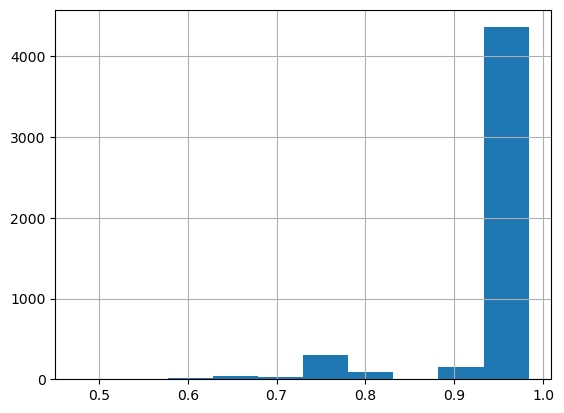

In [ ]:
df_test['pred_prob'].hist();

In [ ]:
df_test[df_test['pred_prob']<0.85][:500]

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,merchant_name_combined,true_label,label,pred_merchant,pred_prob
4,9796686754,Wal-Mart Super WAL-SAMS SPRINGFIELD MO. Channe...,Wal-Mart Super WAL-SAMS SPRINGFIELD MO. Type: ...,Wal-Mart Super WAL-SAMS SPRINGFIELD MO,Walmart,Smith''s,0,0.310292,Wal Wal-martsuper,0.799137
11,9799290885,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,Walmart,Synchrony,0,0.232759,Wal Wal-martsuper,0.775473
12,9798904474,Walmart.com Bentonville AR XX SIG PURCH 05/13 ...,Walmart.com Bentonville AR XX SIG PURCH 05/13 ...,Walmart.com Bentonville AR XX SIG PURCH 05/13 ...,Walmart,QuikTrip,0,0.075148,Wal Wal-martsuper,0.751793
17,9801927063,PURCHASE AUTHORIZED ON 05/11 WALMART.COM 800-9...,PURCHASE AUTHORIZED ON 05/11 WALMART.COM 800-9...,PURCHASE AUTHORIZED ON 05/11 WALMART.COM 800-9...,Walmart,Cash App,0,0.078535,Wal Wal-martsuper,0.735269
28,9799263021,05/13 22:02 WAL-MART # JONESBORO AR CKCD DEBIT...,05/13 22:02 WAL-MART # JONESBORO AR CKCD DEBIT...,05/13 22:02 WAL-MART # JONESBORO AR CKCD DEBIT,Walmart,Marathon Petroleum,0,0.257865,Wal Wal-martsuper,0.751371
...,...,...,...,...,...,...,...,...,...,...
4960,9807244423,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,PURCHASE AUTHORIZED ON 05/14 WM SUPERC Wal-Mar...,Walmart,Spinstersis,0,0.051089,Wal Wal-martsuper,0.772779
4965,9808452776,Walmart.com 05/14 #XXXXX REFUND Walmart.com Be...,Walmart.com 05/14 #XXXXX REFUND Walmart.com Be...,Walmart.com 05/14 #XXXXX REFUND Walmart.com Be...,Walmart,K Stop Convenience,0,0.018743,Wal Wal-martsuper,0.713919
4971,9798778036,Point of Sale Debit L341 TIME 04:30 PM DATE 05...,Point of Sale Debit L341 TIME 04:30 PM DATE 05...,Point of Sale Debit L341 TIME 04:30 PM DATE 05...,Walmart,Ross Stores,0,0.114881,Wal Wal-martsuper,0.766499
4981,9807593604,CHECKCARD WALMART STA ELENA LA LIBERTAD XXXXX ...,CHECKCARD WALMART STA ELENA LA LIBERTAD XXXXX ...,CHECKCARD WALMART STA ELENA LA LIBERTAD XXXXX ...,Walmart,Lyft,0,0.116438,Wal Wal-martsuper,0.751746


In [ ]:
df_test.shape

(5000, 10)

In [ ]:
df_test['sentence'][100:150]

100    Deposit Debit Ca Earnin CEEEE_B Palo Alto CA D...
101    Zelle payment from AMY HAYES for \"vanishing b...
102    EARNIN CHGFC_B PALO ALTO CA 05/14. Channel: No...
103    PURCHASE AUTHORIZED ON 05/13 MCDONALD''S F IRV...
104    Debit Card Credit EARNIN CCHGA_B PALO ALTO CA....
105    Zelle payment from SUSAN BRODBECK BACsggj269q0...
106    POS Payment McDonalds 154-XXX VA # . Channel: ...
107    ONLINE TRANSFER FROM HUDSON A WAY2SAVE SAVINGS...
108    EARNIN CDHJA_B PALO ALTO CA 05/14. Channel: No...
109    Earnin CEGJA_B Palo Alto CA. Channel: None. Am...
110    ONLINE TRANSFER FROM BENNETT T WAY2SAVE SAVING...
111    Zelle payment from ALEXIS GAUDET BACxe32r3prx....
112    PURCHASE AMZN Mktp US*SY1BN Amzn.com/billWA XX...
113    CASH APP*ERIC LOLA BAR. Channel: None. Amount:...
114    Zelle payment from SHAVONNE MORENO BACpwpbspl0...
115    McDonalds 05-12 BROOKSVILLE FL DEBIT CARD PURC...
116    CHECKCARD CASH APP*WE DESIG XXXXX CA XXXXX XXX...
117    AMZN Mktp US*WN8Q06S Amz

In [ ]:
model.encode(df_test['sentence'][istart:istart+batch_size].tolist())

array([[-0.00816036,  0.27537555,  0.14324246, ...,  0.0999889 ,
        -0.0035936 ,  0.07809736],
       [ 0.02443847, -0.07863627,  0.01445072, ...,  0.02271993,
         0.03442278,  0.02410999],
       [-0.01848849,  0.26305526,  0.12530893, ...,  0.09496655,
         0.00565742,  0.07274164],
       ...,
       [ 0.02032459, -0.06118753,  0.01493401, ..., -0.00625443,
         0.10024939,  0.12695931],
       [-0.01988285, -0.1525213 ,  0.0045229 , ..., -0.01461221,
         0.02463034,  0.0660398 ],
       [-0.01051987, -0.06855395,  0.00723861, ..., -0.00558885,
         0.0144608 ,  0.05602989]], dtype=float32)

In [ ]:
df_test.loc[istart:istart+batch_size-1,'pred_merchant'].shape

(100,)

In [ ]:
df_test.loc[0:100,'label'].shape

(101,)

In [ ]:
df_test[0:100].shape

(100, 10)

In [ ]:
istart+batch_size

100

In [ ]:

len(predicted_merchant)

100

In [ ]:
tx_embedding = model.encode(df_test['sentence'][0:2])

In [ ]:
tx_embedding.shape

(2, 768)

torch.Size([2, 85500])

torch.return_types.max(
values=tensor([0.9616, 0.9750]),
indices=tensor([117,  17]))

tensor([117,  17])

In [ ]:
df_test['merchant_name_combined']

0         Wells Fargo
1         McDonald''s
2            Cash App
3             Verizon
4            Smith''s
            ...      
4995    Chumba Casino
4996            Zelle
4997           Crenco
4998          Empower
4999            Zelle
Name: merchant_name_combined, Length: 5000, dtype: string

In [ ]:
matched_merchants = similarities.max(axis=1)
matched_merchants

NameError: name 'similarities' is not defined

In [ ]:
similarity_score = matched_merchants[0]
similarity_score

tensor([0.9629, 0.9737])

In [ ]:
matched_merchants

NameError: name 'matched_merchants' is not defined

Load model

In [ ]:
print(sentence_transformers.__version__)

3.0.0


In [ ]:
from sentence_transformers import SentenceTransformerModelCardData
from datasets import load_dataset


In [ ]:
# 1. Load a model to finetune with 2. (Optional) model card data
model = SentenceTransformer(
    "microsoft/mpnet-base",
    model_card_data=SentenceTransformerModelCardData(
        language="en",
        license="apache-2.0",
        model_name="MPNet base trained on AllNLI triplets",
    )
)

# 3. Load a dataset to finetune on
dataset = load_dataset("sentence-transformers/all-nli",'pair-score')

No sentence-transformers model found with name microsoft/mpnet-base. Creating a new one with mean pooling.
Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Generating train split:   0%|          | 0/942069 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/19657 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/19656 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'score'],
        num_rows: 942069
    })
    dev: Dataset({
        features: ['sentence1', 'sentence2', 'score'],
        num_rows: 19657
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'score'],
        num_rows: 19656
    })
})

In [ ]:
train_dataset = dataset['train']

In [ ]:
train_dataset[0]

{'sentence1': 'A person on a horse jumps over a broken down airplane.',
 'sentence2': 'A person is training his horse for a competition.',
 'score': 0.5}

In [ ]:
#train_dataloader = DataLoader(train_examples, shuffle=True, batch_size = 128)

In [ ]:
len(train_dataloader)

668

In [ ]:
#train_loss = losses.CosineSimilarityLoss(model)

In [ ]:
train_loss

NameError: name 'train_loss' is not defined

## Tune the model

In [ ]:
model.fit(train_objectives = [(train_dataloader, train_loss)], epochs = 1 , warmup_steps = 100)

Detected kernel version 4.14.343, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss
500,0.020500


In [ ]:
# save model

## Evaluation

In [ ]:
trx_descriptions = df_val['sentence'].tolist()
merchants = df_val['merchant_name_combined'].tolist()
trx_embeddings = model.encode(trx_descriptions)
merchants_embeddings = model.encode(merchants)

In [ ]:
print(trx_embeddings.shape)
print(merchants_embeddings.shape)

(9500, 768)
(9500, 768)


In [ ]:
import numpy as np

In [ ]:
## look into numba
cosine_similarity(trx_embeddings, merchants_embeddings).shape
df_val['cos_similarity']=np.diag(cosine_similarity(trx_embeddings, merchants_embeddings))

In [ ]:
df_val

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,merchant_name_combined,true_label,label,cos_similarity
0,9798760350,Debit Purchase Wal-mart Super Cbrookings Sd 05...,Debit Purchase Wal-mart Super Cbrookings Sd 05...,Debit Purchase Wal-mart Super Cbrookings Sd 05...,Walmart,Exotic S Shop,0,0.328529,0.000262
1,9806775557,MONEY TRANSFER AUTHORIZED ON 05/13 CASH APP*JE...,MONEY TRANSFER AUTHORIZED ON 05/13 CASH APP*JE...,MONEY TRANSFER AUTHORIZED ON 05/13 CASH APP*JE...,Cash App,Acorns,0,0.265679,-0.010028
2,9798728894,MONEY TRANSFER AUTHORIZED ON 05/13 FROM Earnin...,MONEY TRANSFER AUTHORIZED ON 05/13 FROM Earnin...,MONEY TRANSFER AUTHORIZED ON 05/13 FROM Earnin...,Earnin,PayPal,0,0.207873,-0.003231
3,9799291124,MONEY TRANSFER AUTHORIZED ON 05/13 CASH APP*JE...,MONEY TRANSFER AUTHORIZED ON 05/13 CASH APP*JE...,MONEY TRANSFER AUTHORIZED ON 05/13 CASH APP*JE...,Cash App,Wells Fargo,0,0.008904,0.001403
4,9799976650,Instant Pmt from Earnin RDBFA_B on 05/14 Ref# ...,Instant Pmt from Earnin RDBFA_B on 05/14 Ref# ...,Instant Pmt from Earnin RDBFA_B on 05/14 Ref# ...,Earnin,Venmo,0,0.054398,-0.010100
...,...,...,...,...,...,...,...,...,...
9495,9799636891,PURCHASE RETURN AUTHORIZED ON 05/13 AMZN Mktp ...,PURCHASE RETURN AUTHORIZED ON 05/13 AMZN Mktp ...,PURCHASE RETURN AUTHORIZED ON 05/13 AMZN Mktp ...,Amazon,TGI Friday''s,0,0.102636,0.001885
9496,9799365097,"AMZN Mktp US GE69A,2YL3 Amzn com WA,05-13-24,C...","AMZN Mktp US GE69A,2YL3 Amzn com WA,05-13-24,C...","AMZN Mktp US GE69A,2YL3 Amzn com WA,05-13-24,C...",Amazon,Amazon,1,0.840733,0.995985
9497,9814848095,ONLINE TRANSFER FROM NAME N WELLS FARGO CLEAR ...,ONLINE TRANSFER FROM NAME N WELLS FARGO CLEAR ...,ONLINE TRANSFER FROM NAME N WELLS FARGO CLEAR ...,Wells Fargo,Wells Fargo,1,0.888943,0.988127
9498,9799827250,MCDONALD''S F ROCKY RIVER OH 05/13. Channel: i...,MCDONALD''S F ROCKY RIVER OH 05/13. Type: merc...,MCDONALD''S F ROCKY RIVER OH 05/13,McDonald''s,Coca-Cola,0,0.085374,-0.001350


In [ ]:
while True:
    pass

KeyboardInterrupt: 

In [ ]:
validate_data[['label', 'true_label','cos_similarity']]

In [ ]:
# reducer = umap.UMAP(n_epochs=400,  n_neighbors=150, min_dist=0.1)
# reducer.fit(merchants_embeddings
# )
# embedding_2d = reducer.transform(merchants_embeddings)
# fig = px.scatter(embedding_2d, x=0, y=1,opacity=0.05, height=500, hover_name=names)
# fig.show()